In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import GPTNeoConfig, GPTNeoModel, GPT2Tokenizer
from transformers import InputExample, InputFeatures
import logging
logging.basicConfig(level=logging.ERROR)

/home/csci8523/hwan0259/.conda/envs/pytorch_gpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-21 12:34:37.985673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# set up device for gpu usage or cpu usage
# torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
import io
train=pd.read_csv("../Dataset/SA_dataset/train.tsv", sep="\t", on_bad_lines='skip')
test=pd.read_csv("../Dataset/SA_dataset/test.tsv", sep="\t", on_bad_lines='skip')
test_check=pd.read_csv("../Dataset/SA_dataset/test_check.csv", sep=",", on_bad_lines='skip')
print(train.head())
print(test.head())
print(test_check.head())

   PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2  
   PhraseId  SentenceId                                             Phrase
0    156061        8545  An intermittently pleasing but mostly routine ...
1    156062        8545  An intermittently pleasing but mostly routine ...
2    156063        8545                                                 An
3    156064        8545  intermittently pleasing but mostly routine effort
4    156065        8545         intermittently pleasing but mostly

In [4]:
# df_train = train
# df_test = test
# df_test_c = test_check

df_train = train[:int(len(train)/2)]
df_test = test[:int(len(test)/2)]
df_test_c = test_check[:int(len(test)/2)]

In [5]:
len(df_test_c)

33146

In [6]:
extracted_col = df_test_c["Sentiment"]
df_test = df_test.join(extracted_col)
df_test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine ...,2
1,156062,8545,An intermittently pleasing but mostly routine ...,2
2,156063,8545,An,2
3,156064,8545,intermittently pleasing but mostly routine effort,2
4,156065,8545,intermittently pleasing but mostly routine,2


In [7]:
df_train = df_train[['Phrase', 'Sentiment']]
df_test = df_test[['Phrase', 'Sentiment']]
df_test.head()

,Phrase,Sentiment
0,An intermittently pleasing but mostly routine ...,2
1,An intermittently pleasing but mostly routine ...,2
2,An,2
3,intermittently pleasing but mostly routine effort,2
4,intermittently pleasing but mostly routine,2


In [8]:
#Check longest string in Phrase
print(df_train.Phrase.str.len().max())
print(df_test.Phrase.str.len().max())

279
256


In [9]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 279
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

LEARNING_RATE = 5e-5
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B", truncation=True, do_lower_case=True)
tokenizer.pad_token = tokenizer.eos_token  

In [10]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.


None None
None None
<|endoftext|> 50256
<|endoftext|> 50256


In [11]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Phrase
        self.targets = self.data.Sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True,
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [12]:
df_train = df_train.dropna()
df_test = df_test.dropna()
df_test

,Phrase,Sentiment
0,An intermittently pleasing but mostly routine ...,2
1,An intermittently pleasing but mostly routine ...,2
2,An,2
3,intermittently pleasing but mostly routine effort,2
4,intermittently pleasing but mostly routine,2
...,...,...
33141,"mistaking the filmmaker in the tall grass ,",2
33142,mistaking the filmmaker in the tall grass,2
33143,mistaking the filmmaker,2
33144,mistaking,2


In [13]:
train_size = 0.8
train_data=df_train.sample(frac=train_size,random_state=200)
valid_data=df_train.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)
test_data = df_test.reset_index(drop=True)

In [28]:
print(train_data[train_data['Phrase'] == ' '].index)
print(valid_data[valid_data['Phrase'] == ' '].index)
print(test_data[test_data['Phrase'] == ' '].index)
len(valid_data)
valid_data = valid_data.drop(404)
valid_data= valid_data.reset_index(drop=True)

test_data = test_data.drop(1390)
test_data= test_data.reset_index(drop=True)

Int64Index([], dtype='int64')
Int64Index([404], dtype='int64')
Int64Index([], dtype='int64')


In [29]:
train_set = SentimentData(train_data, tokenizer, MAX_LEN)
valid_set = SentimentData(valid_data, tokenizer, MAX_LEN)
test_set = SentimentData(test_data, tokenizer, MAX_LEN)

print("TRAIN Dataset: {}".format(train_data.shape))
print("VALID Dataset: {}".format(valid_data.shape))
print("TEST Dataset: {}".format(df_test.shape))

TRAIN Dataset: (62424, 2)
VALID Dataset: (15604, 2)
TEST Dataset: (33146, 2)


In [30]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 4
                }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 4
                }
test_params = {'batch_size': TEST_BATCH_SIZE,
               'shuffle': True,
                'num_workers': 4
                }


train_loader = DataLoader(train_set, **train_params)
valid_loader = DataLoader(valid_set, **valid_params)
test_loader = DataLoader(test_set, **test_params)

In [17]:
class GPTNeoClass(torch.nn.Module):
    def __init__(self):
        super(GPTNeoClass, self).__init__()
        self.l1 = GPTNeoModel.from_pretrained("EleutherAI/gpt-neo-1.3B")
        self.pre_classifier = torch.nn.Linear(2048, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [18]:
model = GPTNeoClass()
model.to(device)

Some weights of GPTNeoModel were not initialized from the model checkpoint at EleutherAI/gpt-neo-1.3B and are newly initialized: ['transformer.h.1.attn.attention.bias', 'transformer.h.21.attn.attention.bias', 'transformer.h.13.attn.attention.bias', 'transformer.h.15.attn.attention.bias', 'transformer.h.9.attn.attention.bias', 'transformer.h.11.attn.attention.bias', 'transformer.h.3.attn.attention.bias', 'transformer.h.19.attn.attention.bias', 'transformer.h.23.attn.attention.bias', 'transformer.h.7.attn.attention.bias', 'transformer.h.17.attn.attention.bias', 'transformer.h.5.attn.attention.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPTNeoClass(
  (l1): GPTNeoModel(
    (wte): Embedding(50257, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
          )
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
          (c_proj): Linear(in_features=819

In [19]:
# Creating the loss function and optimizer
EPOCHS = 1

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [20]:

# Function for a single training iteration
def train_epoch(model, training_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    step = 0
    for d in tqdm(training_loader):
        step = step+1
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        #scheduler.step()
        optimizer.zero_grad()
    
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:
%%time
import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        len(train_set)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        valid_loader,
        loss_fn,
        device,
        len(valid_set)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'GPTNeo_SA_Model')
        best_accuracy = val_acc

Epoch 1/1
----------


100%|██████████| 7803/7803 [2:44:11<00:00,  1.26s/it]  


Train loss 1.2527776115042697 accuracy 0.5214180443419197


 71%|███████▏  | 1393/1951 [09:14<03:42,  2.51it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/csci8523/hwan0259/.conda/envs/pytorch_gpu/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/csci8523/hwan0259/.conda/envs/pytorch_gpu/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 61, in fetch
    return self.collate_fn(data)
  File "/home/csci8523/hwan0259/.conda/envs/pytorch_gpu/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/csci8523/hwan0259/.conda/envs/pytorch_gpu/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 128, in collate
    return elem_type({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/home/csci8523/hwan0259/.conda/envs/pytorch_gpu/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 128, in <dictcomp>
    return elem_type({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/home/csci8523/hwan0259/.conda/envs/pytorch_gpu/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 120, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/home/csci8523/hwan0259/.conda/envs/pytorch_gpu/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 162, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


In [31]:
# Get model performance (accuracy and loss)
val_acc, val_loss = eval_model(
    model,
    valid_loader,
    loss_fn,
    device,
    len(valid_set)
)
    
print(f"Val   loss {val_loss} accuracy {val_acc}")
print()

100%|██████████| 1951/1951 [12:44<00:00,  2.55it/s]

Val   loss 1.2232231805564073 accuracy 0.5292873622148168



In [ ]:
# 2 hours 40 minutes to run

In [23]:
list1= []
for t_ac in history['train_acc']:
    t_ac = torch.Tensor.cpu(t_ac).numpy()
    list1.append(t_ac)

list2= []
for t_va in history['val_acc']:
    t_va = torch.Tensor.cpu(t_va).numpy()
    list2.append(t_va)

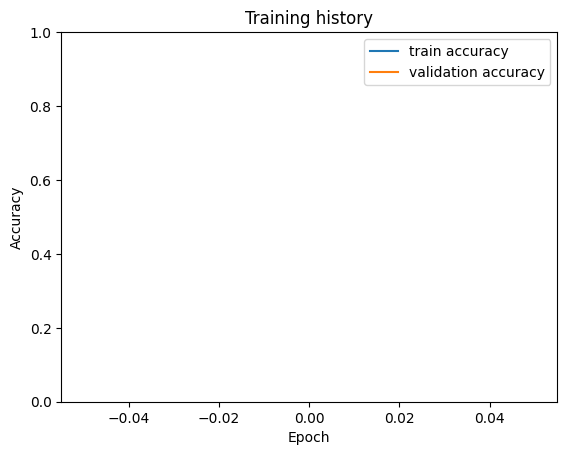

In [24]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy

plt.plot(list1, label='train accuracy')
plt.plot(list2, label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [25]:
model.load_state_dict(torch.load('GPTNeo_SA_Model'))

FileNotFoundError: [Errno 2] No such file or directory: 'GPTNeo_SA_Model'

In [32]:
# Get model performance (accuracy and loss)
test_acc, test_loss = eval_model(
  model,
  test_loader,
  loss_fn,
  device,
  len(test_set)
)

100%|██████████| 4143/4143 [27:18<00:00,  2.53it/s]


In [33]:
test_acc.item()

0.940622737146995

In [ ]:
#Example of sentiment analysis

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [ ]:
# sentiment
# 0 - 4
# one of five labels (from very negative to very positive)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)


output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {prediction.item()}')